In [1]:
import numpy as np
from matplotlib import pyplot as plt

from warper import simulate_2d_anharmonic_multinoise as simulate_2d_anharmonic_multinoise

from multiprocessing import Pool

import os, pickle
from tqdm.notebook import tqdm

import pandas as pd

In [2]:
pool = Pool(4)

In [3]:
def get_RSH(A,B,g0,b,ka,th, qc, qw):
    o0 = np.sqrt(-A)
    mu = ka*th / (ka+th)
    den= (o0**2+th**2+g0*mu)**2+b**2*th**2
    
    Sw = qw/g0/2/ka**2*(ka**2+o0**2+g0*ka+b**2)
    Sc = qc/g0/2 * (th/ka)**2 / den*( (o0**2+th**2+g0*mu)*(o0**2+ka**2+g0*mu)+b**2*th**2)
    
    Rw = qw/g0/2/o0**2/ka**2 * (o0**2+ka**2)
    Rc = qc/g0/2 * (th/ka)**2 / den*( (o0**2+th**2+g0*mu)*(o0**2+ka**2+g0*mu*(ka/th)**2)+b**2*th**2)
                            
    Hw = - 1/2/g0/ka**2*b
    Hc = qc/g0/2 * (th/ka)**2 / den* b*(ka-th)*(ka+th)
    
    R = Rw+Rc
    S = Sw+Sc
    H = Hw+Hc
    return R,S,H, 2*(R*S+H**2)

def mean_with_err(arr, axis):
    return arr.mean(axis=axis), arr.std(axis=axis)/np.sqrt(arr.shape[axis])

In [4]:
# params - A,B,C,D,F,g0,b,ka

params = [
]

# bs =  (0,1,2,3,4,5,6,8,10,12,14,16,18,20,22,24,26,28,30)
bs =  (0,3,8,10,16,20,24,30)

# bs =  (0,3,6,10)#,12,14,16,18,20,22,24,26,28,30)
params += [dict(A=-1,B=0,C=0,D=0,F=0,g0=1,b=b,ka=1, th=1, qw=1, qc=1) for b in bs]
params += [dict(A=15,B=10,C=0,D=0,F=0,g0=1,b=b,ka=1, th=1, qw=1, qc=1) for b in bs]
params += [dict(A=15,B=10,C=1,D=0.05,F=15,g0=1,b=b,ka=1, th=1, qw=1, qc=1) for b in bs]

(bs_expected, R_expected, S_expected, H_expected
) = np.array([((b,)+ get_RSH(A=-1,B=0,g0=1,b=b,ka=1, th=1, qw=1, qc=1)[:3] )
              for b in np.linspace(min(bs), max(bs))]).T

df = pd.DataFrame(params)

In [7]:
def f(row):
    return pd.Series(get_RSH(row.A, row.B, row.g0, row.b, row.ka, row.th, row.qc, row.qw),index=("R","S","H","varL"))
df = pd.concat([df, df.apply(f, axis=1)], axis=1, sort=False)

# df["S_init"] = 1/df.g0/2/df.ka**2*(df.ka**2+df.g0*df.ka+df.b**2)

# df["R_init"] = df.A/df.B/2
# df.loc[df.A<0,"R_init"] = 7

# df["H_init"] = - 1/2/df.g0/df.ka**2*df.b

/home/ashot/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


In [8]:
df["S_init"] = 0
df["R_init"] = 0
df["H_init"] = 0

In [9]:
N=4000000
warmup=0
dt=0.001
samples=400
skip=1000
runs=8
time = np.linspace(0,N//skip *dt, N//skip)

dump_to_disk = False

In [10]:
(len(df) * N * runs * samples *4 // skip) * 4 / 1024**3

4.57763671875

In [ ]:
results = []
for row in tqdm(df.itertuples(), total=len(df)):
#     if row.Index <40:
#         continue
    kwargs = dict(x0=np.zeros(samples),y0=np.zeros(samples),
                  vx0=np.zeros(samples),vy0=np.zeros(samples),
        N=N, samples=samples,
        dt=dt, warmup=warmup, skip=skip,
        A=row.A,B=row.B,C=row.C,D=row.D,F=row.F,
        gamma0=row.g0,b=row.b, kappa=row.ka, theta=row.th,
        q_white=row.qw, q_colored=row.qc)
    res = simulate_2d_anharmonic_multinoise(pool,runs,**kwargs)
    if dump_to_disk:
        np.save(f"results/{row.Index}", res)
    else:
        results.append(np.array(res[:4], dtype="float32"))

In [10]:
results = np.array(results)

### Load dumped data

In [ ]:
import os
n_files = len(os.listdir("results"))

In [ ]:
np.load("results/1.npy").shape

In [ ]:
results = np.zeros((n_files, 4, 800, 5000))

In [ ]:
for i in tqdm(range(n_files)):
    results[i] = np.load(f"results/{i}.npy")[:4,:,-5000:]

In [18]:
results[:,:,:,:].shape

(57, 4, 800, 10000)

### Start Analisys

In [11]:
cov = np.einsum("iakj,ibkj->ijab", results[:,:4,:,:],results[:,:4,:,:],optimize=True)/(results.shape[2]-1)

In [12]:
cov.shape

(24, 4000, 4, 4)

In [18]:
sp = 10
cov_R = cov[:,::sp,(0,1),(0,1)].transpose(1,0,2).reshape(-1, cov.shape[0]*2)
cov_S = cov[:,::sp,(2,3),(2,3)].transpose(1,0,2).reshape(-1, cov.shape[0]*2)
cov_H = cov[:,::sp,(0,1,2,3),(3,2,1,0)].transpose(1,0,2).reshape(-1, cov.shape[0]*4)
cov_Z = cov[:,::sp,(0,0,1,1,2,2,3,3),(1,2,0,3,0,3,1,2)].transpose(1,0,2).reshape(-1, cov.shape[0]*8)

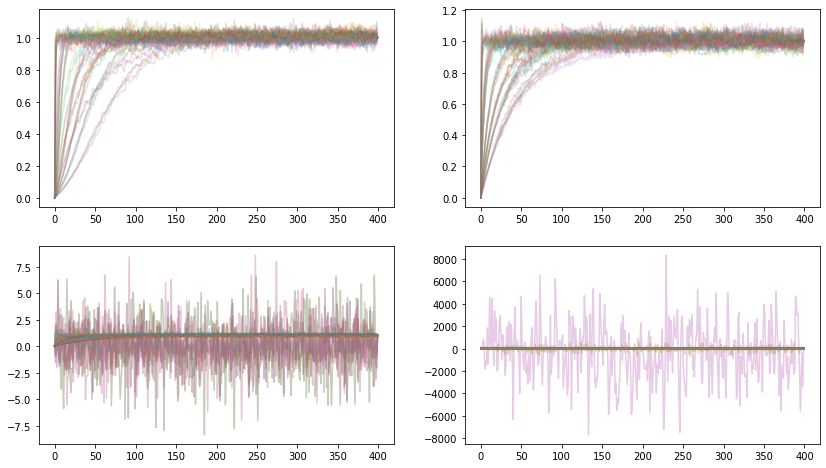

In [19]:
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
plt.plot(cov_R/cov_R[-1], alpha=0.2);
plt.subplot(2,2,2)
plt.plot(cov_S/cov_S[-1], alpha=0.2);
plt.subplot(2,2,3)
plt.plot(cov_H/cov_H[-1], alpha=0.2);
plt.subplot(2,2,4)
plt.plot(cov_Z/cov_Z[-1], alpha=0.2);

In [20]:
stationari_treshold = 3000

In [21]:
results.shape

(24, 4, 3200, 4000)

In [22]:
Rx,Ry, Sx, Sy = results[...,stationari_treshold::10].var(axis=2).transpose(1,0,2)
Lx = results[:,0] * results[:,3]
Ly = results[:,1] * results[:,2]

Hx = Lx.mean(axis=1)
Hy = Ly.mean(axis=1)

In [23]:
df["Rx"], df["Rx_err"]= mean_with_err(Rx,axis=-1)
df["Ry"], df["Ry_err"]= mean_with_err(Ry,axis=-1)
df["Sx"], df["Sx_err"]= mean_with_err(Sx,axis=-1)
df["Sy"], df["Sy_err"]= mean_with_err(Sy,axis=-1)
df["Hx"], df["Hx_err"]= mean_with_err(Hx,axis=-1)
df["Hy"], df["Hy_err"]= mean_with_err(Hy,axis=-1)

# df["Rx"], df["Rx_err"]= mean_with_err(Rx,axis=-1)


In [24]:
df[sorted(df.columns)].round(4)

,A,B,C,D,F,H,H_init,Hx,Hx_err,Hy,...,Sx_err,Sy,Sy_err,b,g0,ka,qc,qw,th,varL
0,-1,0.00,0,0.00,0,0.0,0,-0.0002,0.0005,0.0002,...,0.0048,1.995800,0.0047,0,1,1,1,1,1,6.0
1,-1,0.00,0,0.00,0,-1.5,0,-1.4971,0.0012,1.4975,...,0.0171,6.516100,0.0153,3,1,1,1,1,1,24.0
2,-1,0.00,0,0.00,0,-4.0,0,-3.9571,0.0047,3.9566,...,0.0749,33.906200,0.0675,8,1,1,1,1,1,134.0
3,-1,0.00,0,0.00,0,-5.0,0,-4.9372,0.0070,4.9376,...,0.1169,52.090000,0.1113,10,1,1,1,1,1,206.0
4,-1,0.00,0,0.00,0,-8.0,0,-7.7023,0.0158,7.7027,...,0.2979,128.298492,0.2861,16,1,1,1,1,1,518.0
5,-1,0.00,0,0.00,0,-10.0,0,-9.4423,0.0247,9.4446,...,0.6518,201.338394,0.3249,20,1,1,1,1,1,806.0
6,-1,0.00,0,0.00,0,-12.0,0,-11.1719,0.0341,11.1751,...,0.6753,296.195312,0.6509,24,1,1,1,1,1,1158.0
7,-1,0.00,0,0.00,0,-15.0,0,-13.1728,0.0492,13.1783,...,0.8218,450.656006,0.8332,30,1,1,1,1,1,1806.0
8,2,0.14,0,0.00,0,NaN,0,0.0019,0.0010,-0.0017,...,0.0054,2.079600,0.0054,0,1,1,1,1,1,NaN
9,2,0.14,0,0.00,0,NaN,0,-1.4324,0.0019,1.4326,...,0.0169,6.444100,0.0149,3,1,1,1,1,1,NaN


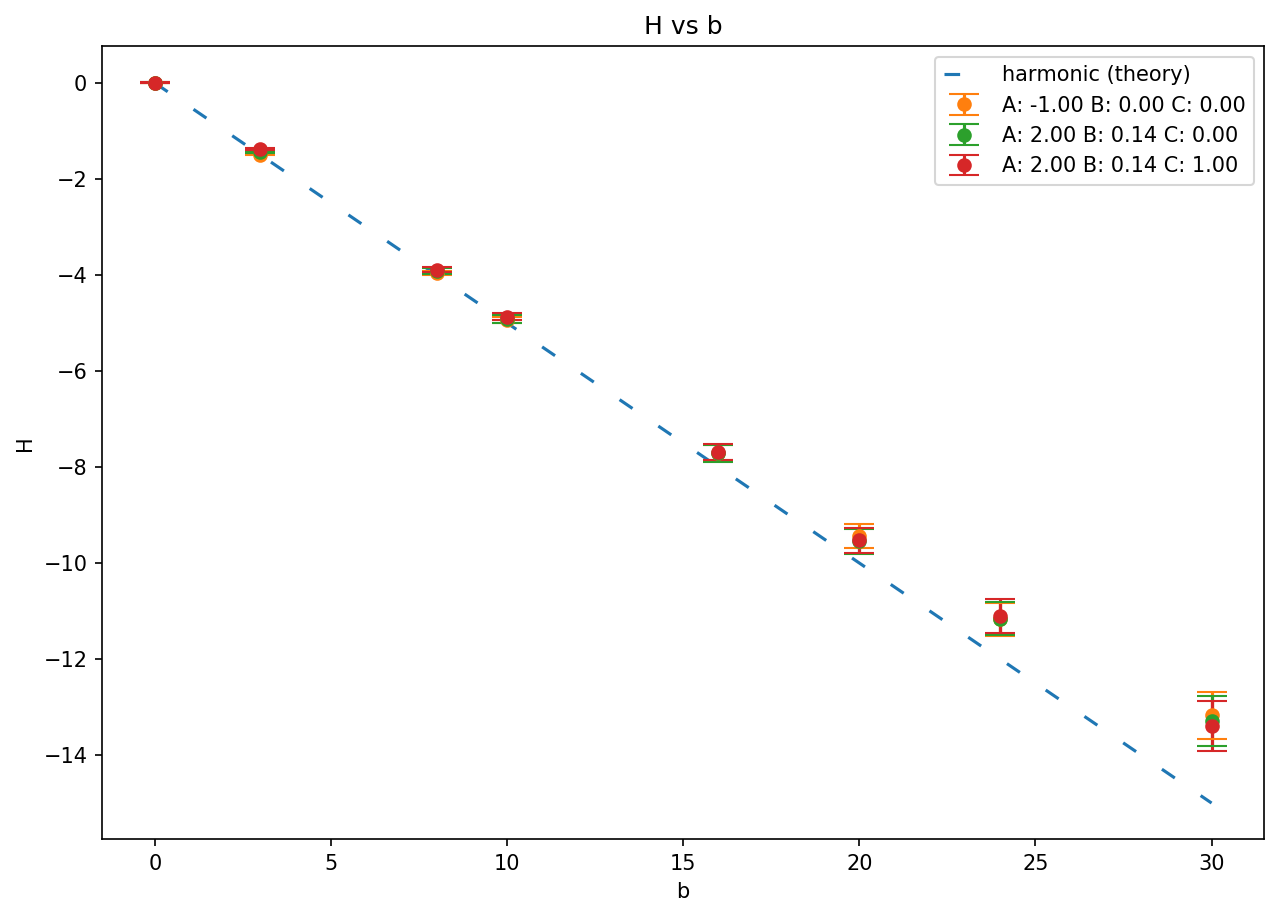

In [41]:
gb=df.groupby(["A","B","C","D","F"])

plt.figure(figsize=(10,7), dpi=150)
plt.title("H vs b")
plt.xlabel("b");plt.ylabel("H")
plt.plot(bs_expected, H_expected,
         ls=(0, (5, 10)), label="harmonic (theory)")
for key in gb.groups:
    gp = gb.get_group(key)
#     plt.plot(gp.b, gp.Hx)
    plt.errorbar(gp.b, gp.Hx, yerr=gp.Hx_err*10, capsize=7, marker="o", ls="none", 
                 label=f"A: {gp.A.mean():0.2f} B: {gp.B.mean():0.2f} C: {gp.C.mean():0.2f}")
# plt.xlim(-1,5)
# plt.ylim(-4,1)
plt.legend()

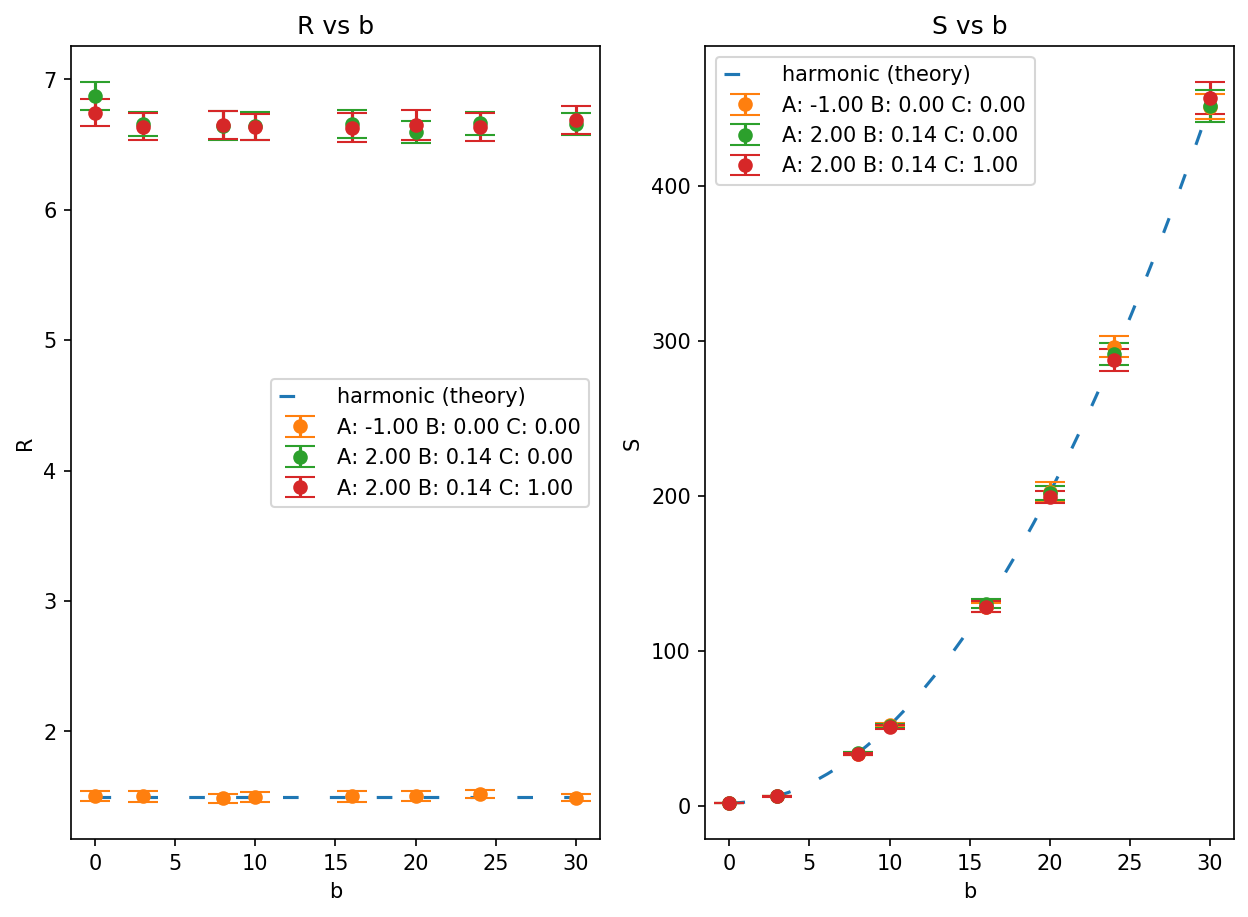

In [42]:
gb=df.groupby(["A","B","C","D","F"])

plt.figure(figsize=(10,7), dpi=150)
plt.subplot(121)
plt.title("R vs b")
plt.xlabel("b");plt.ylabel("R")
plt.plot(bs_expected, R_expected,ls=(0, (5, 10)), label="harmonic (theory)")
for key in gb.groups:
    gp = gb.get_group(key)
#     plt.plot(gp.b, gp.Hx)
    plt.errorbar(gp.b, gp.Rx, yerr=gp.Rx_err*10, capsize=7, marker="o", ls="none", 
                label=f"A: {gp.A.mean():0.2f} B: {gp.B.mean():0.2f} C: {gp.C.mean():0.2f}")
plt.legend()

plt.subplot(122)
plt.title("S vs b")
plt.xlabel("b");plt.ylabel("S")
plt.plot(bs_expected, S_expected, ls=(0, (5, 10)), label="harmonic (theory)")
for key in gb.groups:
    gp = gb.get_group(key)
#     plt.plot(gp.b, gp.Hx)
    plt.errorbar(gp.b, gp.Sx, yerr=gp.Sx_err*10, capsize=7, marker="o", ls="none", 
                label=f"A: {gp.A.mean():0.2f} B: {gp.B.mean():0.2f} C: {gp.C.mean():0.2f}")
plt.legend()

In [ ]:
gb.groups

In [ ]:
dir(gb)

In [ ]:
R_sample = results.var(axis=2)[:,0] 
S_sample = results.var(axis=2)[:,2]

In [ ]:
L = (results[:,0] * results[:,3] - results[:,1] * results[:,2])
H_sample = L.mean(axis=1)/2

In [ ]:
H_sample.shape

In [ ]:
H_sample[:,-3000:].mean(axis=1)

In [ ]:
np.sqrt(H_sample[:,-3000:].var(axis=1)/3000)

In [ ]:
H

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(131)
plt.scatter(S, S_sample[..., -1])
plt.subplot(132)
plt.scatter(R, R_sample[..., -1])
plt.subplot(133)
plt.scatter(H, H_sample[..., -1])

In [ ]:
results.shape

In [ ]:
L.shape

In [ ]:
# T = results[:,2,:,:]
T = L/2
hlines = H

In [ ]:
T.shape[0]

In [ ]:
fig, axs = plt.subplots(1+T.shape[0]//2,2,figsize=(14,8),dpi=120)
for ax, xi,h in zip(axs.flatten(),T[:,:,:], hlines):
    ax.plot(time, xi.mean(axis=0))
    ax.hlines(y=h, xmin=0, xmax=max(time), colors="r")
# plt.show()

In [ ]:
L.shape

In [ ]:
plt.hist(L[0,:,-1], bins=100);

In [ ]:
L[1,:,-1].mean()

In [ ]:
sorted(L[1,:,-1])[1600]

In [ ]:
L.shape

In [ ]:
plt.figure(figsize=(14,8))
plt.plot(L[1,2,3000:])